In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Đặt seed ngẫu nhiên
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cpu


In [2]:
# Đọc dữ liệu
df = pd.read_csv('Gold Futures Historical Data.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,02/28/2025,"2,862.20","2,903.00","2,909.00","2,859.00",NaN,-1.63%
1,02/27/2025,"2,909.70","2,937.30","2,937.40","2,893.90",0.08K,-0.71%
2,02/26/2025,"2,930.60","2,929.00","2,942.00","2,903.30",163.37K,0.40%
3,02/25/2025,"2,918.80","2,968.50","2,970.40","2,897.00",234.85K,-1.50%
4,02/24/2025,"2,963.20","2,950.40","2,974.00","2,936.80",162.78K,0.34%


In [3]:
# Tiền xử lý dữ liệu
df['Date'] = pd.to_datetime(df['Date'])

# Xử lý các cột số
for col in ['Price', 'Open', 'High', 'Low']:
    if df[col].dtype == 'object':  # Nếu là kiểu object (chuỗi)
        df[col] = df[col].str.replace('$', '', regex=True)
        df[col] = df[col].str.replace(',', '', regex=True)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Xử lý cột 'Vol.'
if 'Vol.' in df.columns:
    df['Vol.'] = df['Vol.'].replace('', np.nan)
    df['Vol.'] = df['Vol.'].apply(lambda x: float(str(x).replace('K', '')) * 1000 if pd.notna(x) and isinstance(x, str) and 'K' in x else x)
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Vol.'] = df['Vol.'].fillna(df['Vol.'].mean())

# Xử lý cột 'Change %'
if 'Change %' in df.columns:
    if df['Change %'].dtype == 'object':
        df['Change %'] = df['Change %'].str.replace('%', '', regex=True)
        df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce') / 100

# Sắp xếp dữ liệu từ cũ đến mới
df = df.sort_values('Date').reset_index(drop=True)

# Hiển thị dữ liệu sau khi xử lý
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2022-01-03,1800.1,1830.1,1833.0,1798.2,168310.0,-0.0156
1,2022-01-04,1814.6,1801.1,1817.2,1798.1,167710.0,0.0081
2,2022-01-05,1825.1,1815.2,1830.7,1808.2,173340.0,0.0058
3,2022-01-06,1789.2,1810.6,1811.6,1785.4,238640.0,-0.0197
4,2022-01-07,1797.4,1791.0,1798.4,1781.3,238930.0,0.0046


In [4]:
# Chọn các đặc trưng đầu vào
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
data = df[features].values

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Lưu scaler riêng cho giá để sử dụng khi dự đoán
price_scaler = MinMaxScaler(feature_range=(0, 1))
price_data = df[['Price']].values
price_scaler.fit_transform(price_data)

# Chia tập dữ liệu train-test (70-30)
train_size = int(0.9 * len(scaled_data))
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:train_size+test_size]

In [5]:
# Hàm tạo bộ dữ liệu với nhiều đặc trưng
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])  # Lấy tất cả đặc trưng
        y.append(data[i + time_step, 0])  # Chỉ dự đoán giá (Price)
    return np.array(X), np.array(y)

# Sử dụng time_step=100 giống như file gốc
time_step = 100
x, y = create_sequences(scaled_data, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
y_test = y[train_size-100:]

# Chuyển đổi dữ liệu sang torch tensor
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train.reshape(-1, 1)).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test.reshape(-1, 1)).to(device)

print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")

Kích thước X_train: torch.Size([630, 100, 6])
Kích thước X_test: torch.Size([81, 100, 6])


In [7]:
# Định nghĩa mô hình GRU với nhiều đặc trưng đầu vào
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, 
                          num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Chỉ lấy output của step cuối cùng
        return out

# Số đặc trưng đầu vào
input_dim = len(features)

# Khởi tạo mô hình
model = GRUModel(input_dim=input_dim).to(device)
print(model)

GRUModel(
  (gru): GRU(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [8]:
# Định nghĩa loss function và optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
num_epochs = 100
batch_size = 64

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    # Mini-batch training
    permutation = torch.randperm(X_train.size(0))
    total_loss = 0
    
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Đánh giá trên tập test sau mỗi epoch
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
    
    avg_train_loss = total_loss / len(X_train)
    train_losses.append(avg_train_loss)
    val_losses.append(test_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 0.0000, Test Loss: 0.0010
Epoch [20/100], Loss: 0.0000, Test Loss: 0.0007
Epoch [30/100], Loss: 0.0000, Test Loss: 0.0006
Epoch [40/100], Loss: 0.0000, Test Loss: 0.0005
Epoch [50/100], Loss: 0.0000, Test Loss: 0.0005
Epoch [60/100], Loss: 0.0000, Test Loss: 0.0005
Epoch [70/100], Loss: 0.0000, Test Loss: 0.0006
Epoch [80/100], Loss: 0.0000, Test Loss: 0.0005
Epoch [90/100], Loss: 0.0000, Test Loss: 0.0005
Epoch [100/100], Loss: 0.0000, Test Loss: 0.0006


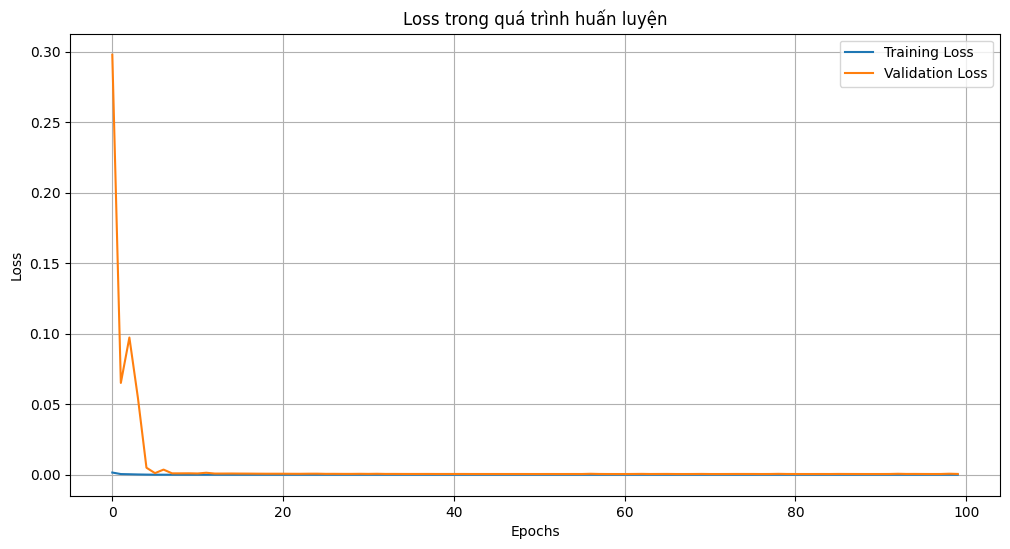

In [9]:
# Vẽ biểu đồ loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss trong quá trình huấn luyện')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Dự đoán trên tập test
model.eval()
with torch.no_grad():
    train_predict = model(X_train).cpu().numpy()
    y_pred = model(X_test).cpu().numpy()

# Chuyển đổi giá trị dự đoán về thang đo ban đầu
y_train_transformed = price_scaler.inverse_transform(y_train.cpu().numpy())
train_predict = price_scaler.inverse_transform(train_predict)
y_test_transformed = price_scaler.inverse_transform(y_test.cpu().numpy())
y_pred_transformed = price_scaler.inverse_transform(y_pred)

# Tính RMSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(y_test_transformed, y_pred_transformed))
mae = mean_absolute_error(y_test_transformed, y_pred_transformed)
mape = np.mean(np.abs((y_test_transformed - y_pred_transformed) / y_test_transformed)) * 100

print(f'Testing RMSE: {rmse:.2f}')
print(f'Testing MAE: {mae:.2f}')
print(f'Testing MAPE: {mape:.2f}%')

Testing RMSE: 31.63
Testing MAE: 25.98
Testing MAPE: 0.95%


In [11]:
# Dự báo tương lai
def predict_future(model, last_sequence, n_future=90):
    model.eval()
    future_predictions = []
    
    # Tạo bản sao của chuỗi cuối cùng
    curr_seq = last_sequence.clone()
    
    with torch.no_grad():
        for _ in range(n_future):
            # Dự đoán giá trị tiếp theo
            pred = model(curr_seq.unsqueeze(0))
            
            # Thêm dự đoán vào danh sách kết quả
            future_predictions.append(pred.item())
            
            # Chuẩn bị dữ liệu cho dự đoán tiếp theo
            # Tạo hàng mới bằng cách sao chép hàng cuối và thay thế giá trị Price
            last_step = curr_seq[-1].clone()
            last_step[0] = pred.item()  # Cập nhật giá mới dự đoán
            
            # Loại bỏ hàng đầu tiên và thêm hàng mới vào cuối
            curr_seq = torch.cat([curr_seq[1:], last_step.unsqueeze(0)])
    
    return np.array(future_predictions).reshape(-1, 1)

# Lấy chuỗi cuối cùng từ dữ liệu test
last_sequence = torch.FloatTensor(scaled_data[-time_step:]).to(device)

# Dự đoán 90 ngày tương lai
future_predictions = predict_future(model, last_sequence, 90)
future_predictions = price_scaler.inverse_transform(future_predictions)

Kích thước y_pred_transformed: (81, 1)
Số dòng của test_predict_dates nếu tính bình thường: 0
Kích thước test_predict_dates sau khi sửa: 81


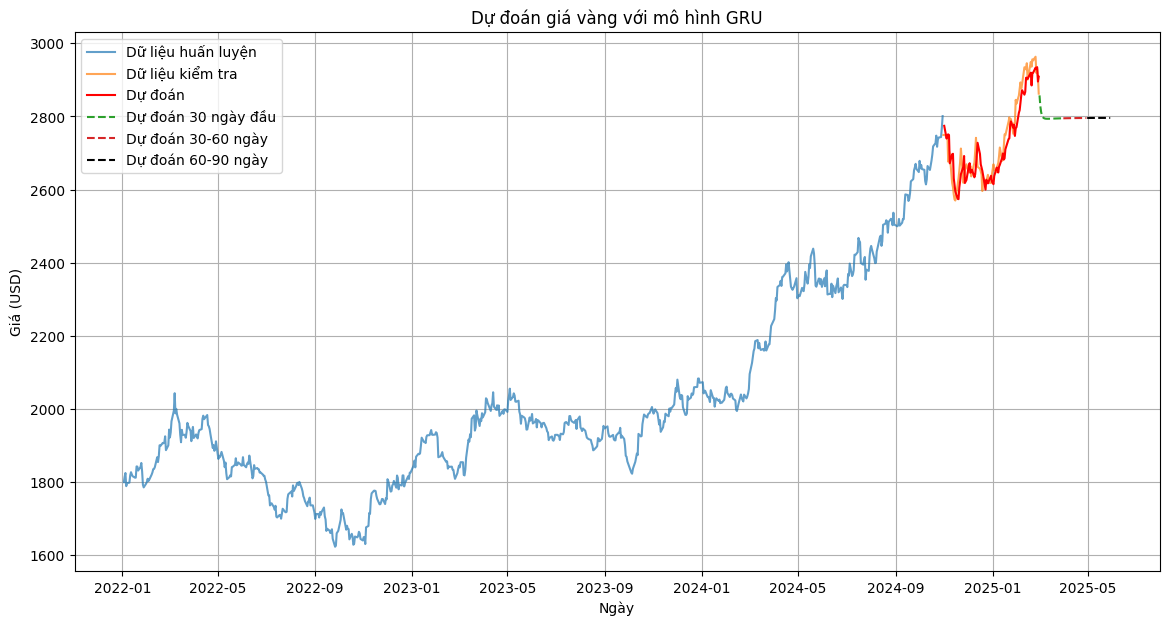

In [12]:
# Vẽ biểu đồ kết quả
plt.figure(figsize=(14, 7))

# Dữ liệu train và test
plt.plot(df['Date'][:train_size], price_data[:train_size], label='Dữ liệu huấn luyện', alpha=0.7)
plt.plot(df['Date'][train_size:], price_data[train_size:], label='Dữ liệu kiểm tra', alpha=0.7)

# Kiểm tra kích thước để gỡ lỗi
print(f"Kích thước y_pred_transformed: {y_pred_transformed.shape}")
print(f"Số dòng của test_predict_dates nếu tính bình thường: {len(df['Date'][train_size+time_step:train_size+time_step+len(y_pred_transformed)])}")

# Sửa lại cách tính dates để khớp với kích thước y_pred_transformed
y_pred_len = len(y_pred_transformed)
# Đảm bảo chỉ lấy đúng số lượng ngày tương ứng với số dự đoán
test_predict_dates = df['Date'][-y_pred_len:] if y_pred_len <= len(df['Date']) else df['Date'][-len(df['Date']):]

# Kiểm tra lại kích thước sau khi sửa
print(f"Kích thước test_predict_dates sau khi sửa: {len(test_predict_dates)}")

# Vẽ đường dự đoán, đảm bảo kích thước khớp nhau
plt.plot(test_predict_dates[:len(y_pred_transformed)], y_pred_transformed[:len(test_predict_dates)], 
         label='Dự đoán', color='red')

# Dự đoán tương lai
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

# Chia dự đoán tương lai thành 3 khoảng thời gian 30 ngày
plt.plot(future_dates[:30], future_predictions[:30], label='Dự đoán 30 ngày đầu', linestyle='--')
plt.plot(future_dates[30:60], future_predictions[30:60], label='Dự đoán 30-60 ngày', linestyle='--')
plt.plot(future_dates[60:], future_predictions[60:], label='Dự đoán 60-90 ngày', linestyle='--', color='black')

plt.title('Dự đoán giá vàng với mô hình GRU')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# In dự đoán cho 10 ngày đầu tiên
print("Dự đoán giá vàng 10 ngày đầu tiên:")
for i in range(10):
    print(f"Ngày {i+1}: ${future_predictions[i][0]:.2f}")

# So sánh với giá hiện tại
current_price = df['Price'].iloc[-1]
next_day_price = future_predictions[0][0]
price_change = ((next_day_price - current_price) / current_price) * 100

print(f"\nGiá hiện tại: ${current_price:.2f}")
print(f"Giá dự đoán ngày tiếp theo: ${next_day_price:.2f}")
print(f"Biến động dự kiến: {price_change:.2f}%")

if price_change > 0:
    print("Dự đoán: Giá sẽ TĂNG ↑")
else:
    print("Dự đoán: Giá sẽ GIẢM ↓")

Dự đoán giá vàng 10 ngày đầu tiên:
Ngày 1: $2857.46
Ngày 2: $2827.98
Ngày 3: $2811.97
Ngày 4: $2803.23
Ngày 5: $2798.57
Ngày 6: $2796.09
Ngày 7: $2794.78
Ngày 8: $2794.09
Ngày 9: $2793.74
Ngày 10: $2793.60

Giá hiện tại: $2862.20
Giá dự đoán ngày tiếp theo: $2857.46
Biến động dự kiến: -0.17%
Dự đoán: Giá sẽ GIẢM ↓
